# Exercice Titanic , Explications Of Parts Of the CODE 

# Importing Libraries 

In [ ]:
import os
import re
import sys
import tarfile
import email
import email.policy

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import urllib.request


# Explications Of : %matplotlib inline


In [ ]:
#Enables inline plotting: Forces matplotlib visualizations to render directly in Jupyter notebooks instead of opening separate windows.

#Embeds static images: Outputs plots as static PNG graphics within the notebook for easy viewing and sharing.

# Importing the functions we need from the libraries 

In [ ]:

#
from collections import Counter
from html import unescape
from scipy.ndimage import shift
from scipy.sparse import csr_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC


# Importing the DATASET FROM THE LINK : "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

In [ ]:
#
TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

# Downlanding The "titanic" data set and verifying if "Train.csv" and "test.csv Exist" ? 

In [ ]:

#
def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

# what (fetch_titanic_data() ) do : 

In [ ]:
#Creates dataset directory: Checks if the TITANIC_PATH folder exists, and creates it (including parent directories) if missing.

#Downloads missing files: For train.csv/test.csv, downloads from DOWNLOAD_URL only if not already present locally.

# Reading the DATA of the Dataset 

In [ ]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
--

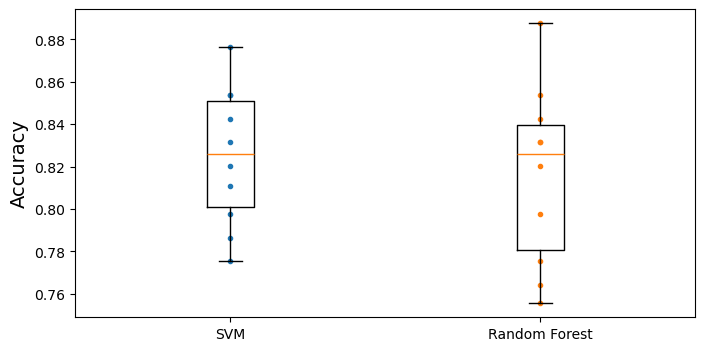

           Survived
AgeBucket          
0.0        0.576923
15.0       0.362745
30.0       0.423256
45.0       0.404494
60.0       0.240000
75.0       1.000000
---

                  Survived
RelativesOnboard          
0                 0.303538
1                 0.552795
2                 0.578431
3                 0.724138
4                 0.200000
5                 0.136364
6                 0.333333
7                 0.000000
10                0.000000
---



In [ ]:

  


#
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

#
print(train_data.head())
print("---")
print()

#
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

#
print(train_data.info())
print("---")
print()

#
train_data[train_data["Sex"]=="female"]["Age"].median()

#
print(train_data.describe())
print("---")
print()

#
print(train_data["Survived"].value_counts())
print("---")
print()

#
print(train_data["Pclass"].value_counts())
print("---")
print()

#
print(train_data["Sex"].value_counts())
print("---")
print()

#
print(train_data["Embarked"].value_counts())
print("---")
print()

#
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

#
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

#
num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

#
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
print(X_train)
print("---")
print()

#
y_train = train_data["Survived"]

#
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

#
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

#
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
print(forest_scores.mean())
print("---")
print()

#
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
print(svm_scores.mean())
print("---")
print()

#
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], tick_labels=["SVM", "Random Forest"])  # actualizado
plt.ylabel("Accuracy", fontsize=14)
plt.show()

#
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()
print(train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean())
print("---")
print()
    
#
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()
print(train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean())
print("---")
print()
